## Model Order Selection for Neural Data

## Loading the data

The data is from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a> 

A simplified version was put together by UPenn: 
[Repository](https://github.com/KordingLab/Neural_Decoding) and 
[Dropbox](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=0)

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
import requests
from tqdm import tqdm, tqdm_notebook
from urllib.request import urlopen
import os

def download_from_url(url, dst):
    """
    @param: url to download file
    @param: dst place to put the file
    """
    file_size = int(urlopen(url).info().get('Content-Length', -1))
    first_byte = 0
    header = {"Range": "bytes=%s" % (file_size)}
    pbar = tqdm_notebook(
        total=file_size, initial=first_byte,
        unit='B', unit_scale=True, desc=dst)
    req = requests.get(url, headers=header, stream=True)
    with(open(dst, 'wb')) as f:
        for chunk in req.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                pbar.update(1024)
    pbar.close()
    return file_size

In [3]:
import os
fn_src = 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1'
fn_dst = 'example_data_s1.pickle'

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    download_from_url(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


The file is a *pickle* data structure, which is a package to serialize python objects into data files. 

In [4]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.
The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction
* `y[i,1] = ` velocity of the monkey's hand in the y-direction 

Each time bin represent `tsamp=0.05` seconds of time. 

In [5]:
tsamp = 0.05  # sampling time in seconds

nt, nneuron = X.shape
nout = y.shape[1]
ttotal = nt*tsamp

print('Number of neurons = %d' % nneuron)
print('Number of time samples = %d' % nt)
print('Number of outputs = %d' % nout)
print('Total time (secs) = %f' % ttotal)

Number of neurons = 52
Number of time samples = 61339
Number of outputs = 2
Total time (secs) = 3066.950000


## Fitting a Memoryless Linear Model

Using a simple linear regression model to fit the data.

In [6]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33)

In [7]:
regr = LinearRegression()

# Fit the model
regr.fit(Xtr,ytr)

# Predict the output on the test data
yhat = regr.predict(Xts)

rsq = r2_score(yts, yhat)
print(rsq)

0.46562333447569565


Plot the predicted vs. true values.  In plot `i=0,1`, plot `yhat[:,i]` vs. `yts[:,i]` with a scatter plot.

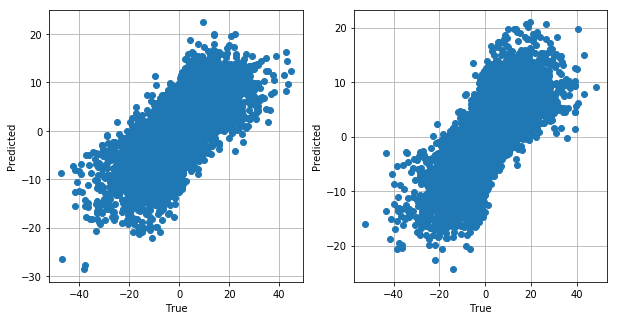

In [8]:
plt.figure(figsize=(10,5))
for i in range(nout):
    plt.subplot(1,nout,i+1)
    plt.plot(yts[:,i],yhat[:,i],'o')
    plt.grid()
    plt.xlabel('True')
    plt.ylabel('Predicted')

## Fitting Models with Delay

Using the delayed version of the features to improve the model accuracy. 

    yhat[i,k] = \sum_{j=0}^{p-1} X[i,j]*w[j,k] + b[k]
    
`p` is the number of features 
`w[j,k]` is a matrix of coefficients

In this model,  `yhat[i,:]` at time `i` was only dependent on the inputs  `X[i,:]` at time `i`.  In signal processing, this is called a *memoryless* model.  However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs `X[i,:]` and the outputs `y[i]`.  For such cases, we can use a model of the form,

    yhat[i+d,k] = \sum_{k=0}^d  \sum_{j=0}^{p-1} \sum_{m=0}^d X[i+m,j]*W[j,m,k] + b[k]
    
where `W` is a 3-dim array of coefficients where:

    W[j,m,k] is the influence of the input X[i+m,j] onto output y[i+d,k]


In signal processing, this model is called an *FIR* filter and `W[j,:,k]` is the *impulse response* from the `j`-th input to the `k`-th output.  The point is that the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.  Hence, it depends on the last `d+1` time steps, not just the most recent time.

To translate this into a linear regression problem, the following function creates a new feature and target matrix where:

    Xdly[i,:] has the rows X[i,:], X[i++1,:], ..., X[i+dly,:]
    ydly[i,:] = y[i+dly,:]
    
Thus, `Xdly[i,:]` contains all the delayed fetaures for the target `yhat`.  Note that if `X` is `n x p` then `Xdly` will be `n-dly x (dly+1)*p`.  


In [9]:
def create_dly_data(X,y,dly):
    """
    Creates delayed data
    """    

    n,p = X.shape
    Xdly = np.zeros((n-dly,(dly+1)*p))
    for i in range(dly+1):
        Xdly[:,i*p:(i+1)*p] = X[dly-i:n-i,:]
    ydly = y[dly:]
    
    return Xdly, ydly


Now fit an linear delayed model with `dly=6` additional delay lags. 

In [10]:
dly = 6
Xdly, ydly = create_dly_data(X,y,dly)

Xtr, Xts, ytr, yts = train_test_split(Xdly, ydly, test_size=0.33)

regr = LinearRegression()

# Fit the model
regr.fit(Xtr,ytr)

# Measure the new r^2 score
yhat = regr.predict(Xts)
rsq = r2_score(yts, yhat)
print(rsq)
    

0.6878043682433503


We can see that the $R^2$ score for the delayed model is higher than the previous one.

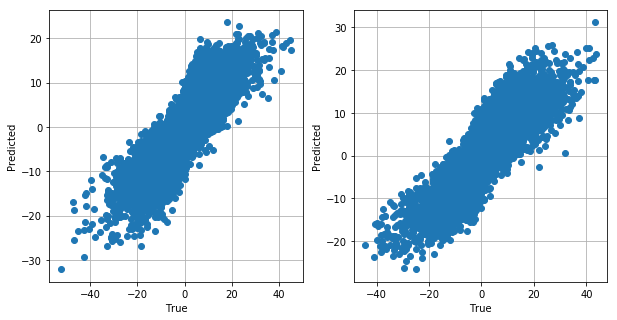

In [11]:
plt.figure(figsize=(10,5))
for i in range(nout):
    plt.subplot(1,nout,i+1)
    plt.plot(yts[:,i],yhat[:,i],'o')
    plt.grid()
    plt.xlabel('True')
    plt.ylabel('Predicted')

*Note*:  Fitting an FIR model with the above method is very inefficient when the number of delays, `dly` is large.  In the above method, the number of columns of `X` grows from `p` to `(dly+1)*p` and the computations become expensive with `dly` is large.  


**A much faster way to fit such models is by using gradient descent in convolutional neural networks.**

## Selecting the Optimal Delay via Model Order Selection

Instead of fixing a delay `dly=6`, we can select the optimal delay using model order selection.  

In [12]:
nred = 6000

Xred = X[:nred]
yred = y[:nred]

Measuring for model orders up to `dmax=15`.  

Creating a delayed matrix data, `Xdly,ydly` from the reduced data, `Xred,yred` using `create_dly_data` with `dly=dmax`.

In [13]:
dmax = 15

Xdly, ydly = create_dly_data(Xred,yred,dmax)

Using K-fold cross validation with `nfold=5` and values of delays `dtest = [0,1,...,dmax]`.

In [14]:
import  sklearn.model_selection 

from tqdm import tqdm_notebook

# Number of folds
nfold = 5

kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

dtest = np.arange(dmax+1)
nd = len(dtest)

Rsq = np.zeros((nd,nfold))
Rss = np.zeros((nd,nfold))

pbar = tqdm_notebook(
    total=nfold*nd, initial=0,
    unit='folds', unit_divisor=nd, desc='Model order test')

for isplit, Ind in enumerate(kf.split(Xdly)):
    
    Itr, Its = Ind        

    for it, d in enumerate(dtest):
        
        Xdly1 = Xdly[:,:(d+1)*nneuron]

        Xtr = Xdly1[Itr,:]
        ytr = ydly[Itr]
        Xts = Xdly1[Its,:]
        yts = ydly[Its]

        regr.fit(Xtr,ytr)

        yhat = regr.predict(Xts)
        Rsq[it,isplit] = r2_score(yts, yhat)   
        Rss[it,isplit] = np.mean((yts-yhat)**2)  
        
        pbar.update(1)
pbar.close()

Text(0, 0.5, 'Test RSS')

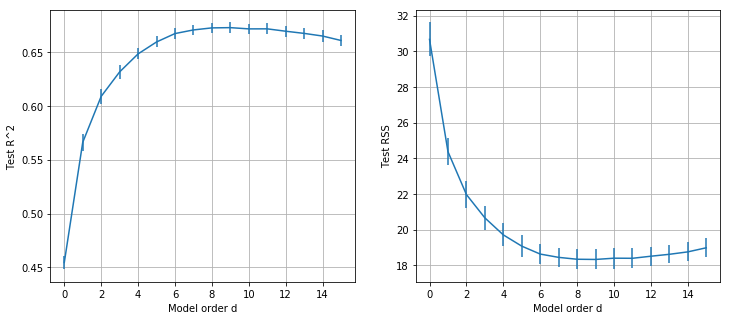

In [15]:
rsq_mean = np.mean(Rsq,axis=1)
rsq_se = np.std(Rsq,axis=1)/np.sqrt(nfold-1)

rss_mean = np.mean(Rss,axis=1)
rss_se = np.std(Rss,axis=1)/np.sqrt(nfold-1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.errorbar(dtest, rsq_mean, rsq_se)
plt.grid()
plt.xlabel('Model order d')
plt.ylabel('Test R^2')

plt.subplot(1,2,2)
plt.errorbar(dtest, rss_mean, rss_se)
plt.grid()
plt.xlabel('Model order d')
plt.ylabel('Test RSS')

Finding the optimal order `d` with the normal rule (i.e. highest test `R^2`)

In [16]:
iopt = np.argmax(rsq_mean)
dopt = dtest[iopt]
print('Optimal model order with normal rule = %d' % dopt)
print('R^2 = %f' % rsq_mean[iopt])

Optimal model order with normal rule = 9
R^2 = 0.672668


Finding the optimal model order via the one **Standard Error** rule (i.e. highest test `R^2` within on SE)

In [17]:
rsq_tgt = rsq_mean[iopt] - rsq_se[iopt]
I = np.where(rsq_mean >= rsq_tgt)[0]
iopt_one_se = I[0]
dopt_one_se = dtest[iopt_one_se]
print('Optimal model order with one SE rule = %d' % dopt_one_se)
print('R^2 = %f' % rsq_mean[iopt_one_se])

Optimal model order with one SE rule = 7
R^2 = 0.670535
